## Import Libraries

In [ ]:
!pip install transformers
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
from torch.nn import BCEWithLogitsLoss, BCELoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score
import pickle
#from transformers import *
from tqdm import tqdm, trange
from ast import literal_eval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 61.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 97.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.2 MB/s eta 0:00:00


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

# Data Exploration

In [ ]:
import pandas as pd
data=pd.read_csv('mrpc_train(entropy).csv')
data.head()

,sentence1,sentence2,label,idx,text,prompt1,prompt2,prompt3,prompt4,prompt5,...,pred2,pred3,pred4,pred5,pred6,pred7,pred8,pred9,entropy,MV
0,""" They are trying to turn him into a martyr , ...",""" We need to take these threats seriously , "" ...",0,1245,"Sentence1: "" They are trying to turn him into ...",Please label if the following two sentences ar...,"Sentence1: "" They are trying to turn him into ...","Given the following two sentences, please clas...",Is it true that the following two sentences ar...,Is it true that the following two sentences ar...,...,1,0,0,0,0,0,0,0,0.503258,0
1,"Of the 23.5 million high-speed lines , 16.3 mi...",A total of 16.3 million lines provided advance...,0,2804,Sentence1: Of the 23.5 million high-speed line...,Please label if the following two sentences ar...,Sentence1: Of the 23.5 million high-speed line...,"Given the following two sentences, please clas...",Is it true that the following two sentences ar...,Is it true that the following two sentences ar...,...,1,1,1,1,1,1,1,1,-0.000000,1
2,The news sent Cisco shares on a tear in after-...,Cisco shares gained $ 1.28 in after-hours trad...,0,3641,Sentence1: The news sent Cisco shares on a tea...,Please label if the following two sentences ar...,Sentence1: The news sent Cisco shares on a tea...,"Given the following two sentences, please clas...",Is it true that the following two sentences ar...,Is it true that the following two sentences ar...,...,1,1,0,1,1,0,1,1,0.764205,1
3,The technology-laced Nasdaq Composite Index .I...,The Standard & Poor 's 500 Index .SPX gained 1...,0,3296,Sentence1: The technology-laced Nasdaq Composi...,Please label if the following two sentences ar...,Sentence1: The technology-laced Nasdaq Composi...,"Given the following two sentences, please clas...",Is it true that the following two sentences ar...,Is it true that the following two sentences ar...,...,0,0,0,0,0,0,0,0,-0.000000,0
4,Doctors would face fines and up to two years i...,Physicians who perform the procedure would fac...,0,1018,Sentence1: Doctors would face fines and up to ...,Please label if the following two sentences ar...,Sentence1: Doctors would face fines and up to ...,"Given the following two sentences, please clas...",Is it true that the following two sentences ar...,Is it true that the following two sentences ar...,...,1,1,1,1,1,1,1,0,0.503258,1


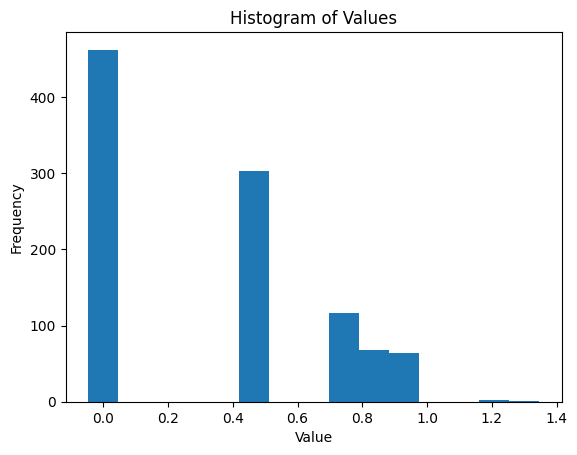

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.hist(data['entropy'], bins=15, align='left')

# Add axis labels and a title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values')
# Display the plot
plt.show()

In [ ]:
# count the unique values in the 'fruit' column
counts = data['entropy'].value_counts()

# print the unique values and their count
for index, count in counts.iteritems():
    print(f"{index}: {count}")

-0.0: 462
0.5032583347756457: 303
0.7642045065086203: 117
0.9182958340544896: 68
0.9910760598382222: 64
1.224394445405986: 2
1.3921472236645345: 1


<ipython-input-10-707faf383544>:5: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, count in counts.iteritems():


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017 entries, 0 to 1016
Data columns (total 34 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sentence1  1017 non-null   object 
 1   sentence2  1017 non-null   object 
 2   label      1017 non-null   int64  
 3   idx        1017 non-null   int64  
 4   text       1017 non-null   object 
 5   prompt1    1017 non-null   object 
 6   prompt2    1017 non-null   object 
 7   prompt3    1017 non-null   object 
 8   prompt4    1017 non-null   object 
 9   prompt5    1017 non-null   object 
 10  prompt6    1017 non-null   object 
 11  prompt7    1017 non-null   object 
 12  prompt8    1017 non-null   object 
 13  prompt9    1017 non-null   object 
 14  label1     1017 non-null   object 
 15  label2     1017 non-null   object 
 16  label3     1017 non-null   object 
 17  label4     1017 non-null   object 
 18  label5     1017 non-null   object 
 19  label6     1017 non-null   object 
 20  label7  

In [ ]:
#qualitative study of those with high entropy
pd.set_option('display.max_colwidth', None)
df_high=data[data['entropy']>0.8]
df_high.head(15)[['text','label','MV']]

,text,label,MV
18,"Sentence1: Board Chancellor Robert Bennett declined to comment on personnel matters Tuesday , as did Mills .\nSentence2: Mr. Mills declined to comment yesterday , saying that he never discussed personnel matters .",1,1
28,"Sentence1: Britain has said it will oppose articles calling for closer coordination of tax and economic policy , to uphold the national right of veto .\nSentence2: Britain has said it wants to haggle over articles of the draft calling for closer coordination of tax and economic policy .",0,0
30,"Sentence1: An evaluation suggested there was no overall net clinical benefit in patients receiving the drug in the study , the companies said in a statement distributed by Business Wire .\nSentence2: An evaluation of 240 arthritis patients suggested there was no overall net clinical benefit from taking the medicine , the companies said in a statement distributed by Business Wire .",1,1
36,"Sentence1: At 5 p.m. EDT , Henri had maximum sustained winds near 50 mph , with some gusts reaching 60 mph .\nSentence2: At 8 p.m. Friday , Henri was becoming disorganized , but still had maximum sustained winds near 50 mph , with stronger gusts .",0,1
38,Sentence1: The Institute for Supply Management said its manufacturing index stood at 53.7 in September .\nSentence2: The Institute for Supply Management 's manufacturing index dipped to 53.7 from 54.7 in August .,0,0
39,"Sentence1: He plans to visit an AIDS clinic in Uganda and meet with infected mothers in Nigeria .\nSentence2: From there he plans to visit South Africa and make stops in Botswana , Uganda and Nigeria .",0,0
43,"Sentence1: On Friday , the Food and Drug Administration approved the use of silicone breast implants with conditions .\nSentence2: The drug was approved for use Friday by the Food and Drug Administration .",0,0
47,"Sentence1: Analysts say Davis , who faces a historic recall election in October , could get a boost in the polls with a budget plan in place .\nSentence2: Analysts say Davis , a Democrat , could get a boost in the polls if the 29-day-old budget crisis is resolved without further delay .",0,0
64,"Sentence1: The long-running newsmagazine Dateline NBC has been cut from three to two airings per week and is searching for a replacement for retiring co-anchor Jane Pauley .\nSentence2: The long-running newsmagazine Dateline NBC has been cut from three to two airings per week , losing its Tuesday berth .",0,1
65,"Sentence1: For the first quarter , HP pulled in $ 2.94 billion and captured 27.9 percent of the market .\nSentence2: H-P came in second with nearly $ 3.32 billion in sales and 26 percent of the market 's revenue .",1,0


In [ ]:
#length calculation for cost computation
df_low=data[data['entropy']<0.2]
print(df_low.shape[0])
df=df_low
df['length1']=df['prompt1'].apply(lambda x:len(x.split()))
df['length2']=df['prompt2'].apply(lambda x:len(x.split()))
df['length3']=df['prompt3'].apply(lambda x:len(x.split()))
df['length4']=df['prompt4'].apply(lambda x:len(x.split()))
df['length5']=df['prompt5'].apply(lambda x:len(x.split()))
df['length6']=df['prompt6'].apply(lambda x:len(x.split()))
df['length7']=df['prompt7'].apply(lambda x:len(x.split()))
df['length8']=df['prompt8'].apply(lambda x:len(x.split()))
df['length9']=df['prompt9'].apply(lambda x:len(x.split()))
df['length10']=df['prompt10'].apply(lambda x:len(x.split()))
df['length11']=df['prompt11'].apply(lambda x:len(x.split()))
df['length12']=df['prompt12'].apply(lambda x:len(x.split()))
df['length13']=df['prompt13'].apply(lambda x:len(x.split()))
df['length']=df['length1']+df['length2']+df['length3']+df['length4']+df['length5']+df['length6']+df['length7']+df['length8']+df['length9']+df['length10']+df['length11']+df['length12']+df['length13']
#sum(df['length'].tolist())

266


In [ ]:
df_low['text'].tolist()[:5]

["Title: Wall St. Bears Claw Back Into the Black Description:  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.",
 "Title: Rescuing an Old Saver Description: If you think you may need to help your elderly relatives with their finances, don't be shy about having the money talk -- soon.",
 'Title: Veteran inventor in market float Description: Trevor Baylis, the veteran inventor famous for creating the Freeplay clockwork radio, is planning to float his company on the stock market.',
 'Title: Quality Gets Swept Away Description: Quality Distribution is hammered after reporting a large loss for the second quarter.',
 "Title: What's Cool In the Pool ... ... And Hot On the Deck Description: Americans are spending more on tricking out the places where they swim. Here's a look at the new wave of accessories"]

In [ ]:
def calculate_alignment(threshold, df_input):
  df_low=df_input[df_input['entropy']<=threshold]
  print(df_low.shape[0])
  df_low_correct1=df_low[df_low['MV']==df_low['label']]
  return df_low_correct1.shape[0]/df_low.shape[0]

In [ ]:
calculate_alignment(0.6, data)

770


0.7584415584415585

In [ ]:
x = [0, 0.2, 0.4, 0.6, 0.8, 1]
y = [calculate_alignment(i, data) for i in x]
y

462
462
462
765
882
1014


[0.7965367965367965,
 0.7965367965367965,
 0.7965367965367965,
 0.7620915032679738,
 0.7290249433106576,
 0.7120315581854043]

462
462
462
765
882
1014


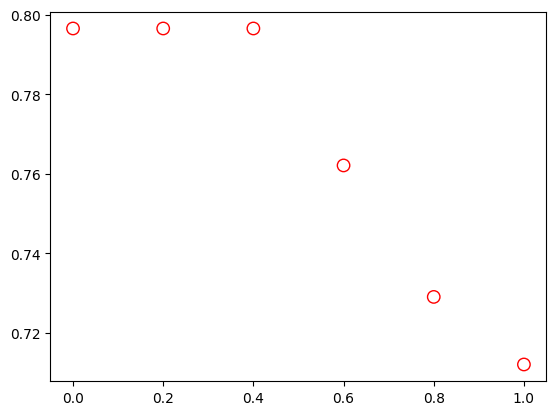

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = [0, 0.2, 0.4, 0.6, 0.8, 1]
y = [calculate_alignment(i, data) for i in x]

plt.scatter(x, y, s=80, facecolors='none', edgecolors='r')
plt.show()

In [ ]:
data['MV_yes']=data['MV'].apply(lambda x:1 if x==1 else 0)
data['MV_no']=data['MV'].apply(lambda x:1 if x==0 else 0)
data['label_yes']=data['label'].apply(lambda x:1 if x==1 else 0)
data['label_no']=data['label'].apply(lambda x:1 if x==0 else 0)

In [ ]:
import pandas as pd
df=data
df=df.sort_values(by='entropy',ignore_index=True)
# Assuming your dataframe is called 'df'
total_rows = df.shape[0]
num_rows_20_percent = int(total_rows * 0.6) #can change this to 0.2, 0.4, 0.6, 0.8
print(num_rows_20_percent)

df['allocate'] = 0  # Initialize the new column with 0
df.loc[:num_rows_20_percent-1, 'allocate'] = 1  # Assign 1 to the first 20% of rows

df.head()

610


,sentence1,sentence2,label,idx,text,prompt1,prompt2,prompt3,prompt4,prompt5,...,pred7,pred8,pred9,entropy,MV,MV_yes,MV_no,label_yes,label_no,allocate
0,Bush said that he ordered the Treasury Departm...,Bush said in a statement that he ordered the U...,1,3154,Sentence1: Bush said that he ordered the Treas...,Please label if the following two sentences ar...,Sentence1: Bush said that he ordered the Treas...,"Given the following two sentences, please clas...",Is it true that the following two sentences ar...,Is it true that the following two sentences ar...,...,1,1,1,-0.0,1,1,0,1,0,1
1,"Strong spokeswoman Stephanie Truog said , "" We...",Strong Financial released a statement Wednesda...,0,3402,Sentence1: Strong spokeswoman Stephanie Truog ...,Please label if the following two sentences ar...,Sentence1: Strong spokeswoman Stephanie Truog ...,"Given the following two sentences, please clas...",Is it true that the following two sentences ar...,Is it true that the following two sentences ar...,...,1,1,1,-0.0,1,1,0,0,1,1
2,Many of the victims of Sunday 's attack had be...,Many of the victims had been headed home for R...,0,3958,Sentence1: Many of the victims of Sunday 's at...,Please label if the following two sentences ar...,Sentence1: Many of the victims of Sunday 's at...,"Given the following two sentences, please clas...",Is it true that the following two sentences ar...,Is it true that the following two sentences ar...,...,1,1,1,-0.0,1,1,0,0,1,1
3,""" The bank requires growth from elsewhere in t...","The Bank of England "" requires growth from els...",1,1410,"Sentence1: "" The bank requires growth from els...",Please label if the following two sentences ar...,"Sentence1: "" The bank requires growth from els...","Given the following two sentences, please clas...",Is it true that the following two sentences ar...,Is it true that the following two sentences ar...,...,1,1,1,-0.0,1,1,0,1,0,1
4,Tyco later said the loan had not been forgiven...,"Tyco has said the loan was not forgiven , but ...",1,142,Sentence1: Tyco later said the loan had not be...,Please label if the following two sentences ar...,Sentence1: Tyco later said the loan had not be...,"Given the following two sentences, please clas...",Is it true that the following two sentences ar...,Is it true that the following two sentences ar...,...,1,1,1,-0.0,1,1,0,1,0,1


In [ ]:
#allocation
yes=[]
no=[]
chatgpt_count=0
#df=data
for index, row in df.iterrows():
    if row['allocate']==1: #edit the threshold here: I tried <-0.2(all human), ==0, <0.2, <0.4, <0.6, <0.8, <1(all chatgpt)
      yes.append(row['MV_yes'])
      no.append(row['MV_no'])
    else:
      yes.append(row['label_yes'])
      no.append(row['label_no'])
df['yes']=yes
df['no']=no
df.head()

,sentence1,sentence2,label,idx,text,prompt1,prompt2,prompt3,prompt4,prompt5,...,pred9,entropy,MV,MV_yes,MV_no,label_yes,label_no,allocate,yes,no
0,Bush said that he ordered the Treasury Departm...,Bush said in a statement that he ordered the U...,1,3154,Sentence1: Bush said that he ordered the Treas...,Please label if the following two sentences ar...,Sentence1: Bush said that he ordered the Treas...,"Given the following two sentences, please clas...",Is it true that the following two sentences ar...,Is it true that the following two sentences ar...,...,1,-0.0,1,1,0,1,0,1,1,0
1,"Strong spokeswoman Stephanie Truog said , "" We...",Strong Financial released a statement Wednesda...,0,3402,Sentence1: Strong spokeswoman Stephanie Truog ...,Please label if the following two sentences ar...,Sentence1: Strong spokeswoman Stephanie Truog ...,"Given the following two sentences, please clas...",Is it true that the following two sentences ar...,Is it true that the following two sentences ar...,...,1,-0.0,1,1,0,0,1,1,1,0
2,Many of the victims of Sunday 's attack had be...,Many of the victims had been headed home for R...,0,3958,Sentence1: Many of the victims of Sunday 's at...,Please label if the following two sentences ar...,Sentence1: Many of the victims of Sunday 's at...,"Given the following two sentences, please clas...",Is it true that the following two sentences ar...,Is it true that the following two sentences ar...,...,1,-0.0,1,1,0,0,1,1,1,0
3,""" The bank requires growth from elsewhere in t...","The Bank of England "" requires growth from els...",1,1410,"Sentence1: "" The bank requires growth from els...",Please label if the following two sentences ar...,"Sentence1: "" The bank requires growth from els...","Given the following two sentences, please clas...",Is it true that the following two sentences ar...,Is it true that the following two sentences ar...,...,1,-0.0,1,1,0,1,0,1,1,0
4,Tyco later said the loan had not been forgiven...,"Tyco has said the loan was not forgiven , but ...",1,142,Sentence1: Tyco later said the loan had not be...,Please label if the following two sentences ar...,Sentence1: Tyco later said the loan had not be...,"Given the following two sentences, please clas...",Is it true that the following two sentences ar...,Is it true that the following two sentences ar...,...,1,-0.0,1,1,0,1,0,1,1,0


# Fine-tuning



Dataset will be tokenized then split into training and validation sets. The validation set will be used to monitor training. For testing a separate test set will be loaded for analysis.

In [ ]:
#df = data #jigsaw-toxic-comment-classification-challenge

In [ ]:
#combined
cols = df.columns
label_cols = list(cols[39:41])
num_labels = len(label_cols)
print('Label columns: ', label_cols)

Label columns:  ['yes', 'no']


In [ ]:
print('Count of 1 per label: \n', df[label_cols].sum(), '\n') # Label counts, may need to downsample or upsample
print('Count of 0 per label: \n', df[label_cols].eq(0).sum())

Count of 1 per label: 
 yes    632
no     385
dtype: int64 

Count of 0 per label: 
 yes    385
no     632
dtype: int64


In [ ]:
df['one_hot_labels'] = list(df[label_cols].values)
df.head()

,sentence1,sentence2,label,idx,text,prompt1,prompt2,prompt3,prompt4,prompt5,...,entropy,MV,MV_yes,MV_no,label_yes,label_no,allocate,yes,no,one_hot_labels
0,Bush said that he ordered the Treasury Departm...,Bush said in a statement that he ordered the U...,1,3154,Sentence1: Bush said that he ordered the Treas...,Please label if the following two sentences ar...,Sentence1: Bush said that he ordered the Treas...,"Given the following two sentences, please clas...",Is it true that the following two sentences ar...,Is it true that the following two sentences ar...,...,-0.0,1,1,0,1,0,1,1,0,"[1, 0]"
1,"Strong spokeswoman Stephanie Truog said , "" We...",Strong Financial released a statement Wednesda...,0,3402,Sentence1: Strong spokeswoman Stephanie Truog ...,Please label if the following two sentences ar...,Sentence1: Strong spokeswoman Stephanie Truog ...,"Given the following two sentences, please clas...",Is it true that the following two sentences ar...,Is it true that the following two sentences ar...,...,-0.0,1,1,0,0,1,1,1,0,"[1, 0]"
2,Many of the victims of Sunday 's attack had be...,Many of the victims had been headed home for R...,0,3958,Sentence1: Many of the victims of Sunday 's at...,Please label if the following two sentences ar...,Sentence1: Many of the victims of Sunday 's at...,"Given the following two sentences, please clas...",Is it true that the following two sentences ar...,Is it true that the following two sentences ar...,...,-0.0,1,1,0,0,1,1,1,0,"[1, 0]"
3,""" The bank requires growth from elsewhere in t...","The Bank of England "" requires growth from els...",1,1410,"Sentence1: "" The bank requires growth from els...",Please label if the following two sentences ar...,"Sentence1: "" The bank requires growth from els...","Given the following two sentences, please clas...",Is it true that the following two sentences ar...,Is it true that the following two sentences ar...,...,-0.0,1,1,0,1,0,1,1,0,"[1, 0]"
4,Tyco later said the loan had not been forgiven...,"Tyco has said the loan was not forgiven , but ...",1,142,Sentence1: Tyco later said the loan had not be...,Please label if the following two sentences ar...,Sentence1: Tyco later said the loan had not be...,"Given the following two sentences, please clas...",Is it true that the following two sentences ar...,Is it true that the following two sentences ar...,...,-0.0,1,1,0,1,0,1,1,0,"[1, 0]"


In [ ]:
labels = list(df.one_hot_labels.values)
comments = list(df.text.values)

Load the pretrained tokenizer that corresponds to your choice in model. e.g.,

```
BERT:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

XLNet:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=False)

RoBERTa:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=False)
```


In order to avoid memory issues with Google Colab, I enforce a max_length of 100 tokens. Note that some sentences may not adequately represent each label because of this.

In [ ]:
from transformers import RobertaTokenizer
max_length = 100
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=False) # tokenizer
encodings = tokenizer.batch_encode_plus(comments,max_length=max_length,pad_to_max_length=True) # tokenizer's encoding method
print('tokenizer outputs: ', encodings.keys())

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


tokenizer outputs:  dict_keys(['input_ids', 'attention_mask'])


In [ ]:
encodings.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
input_ids = encodings['input_ids'] # tokenized and encoded sentences
#token_type_ids = encodings['token_type_ids'] # token type ids
attention_masks = encodings['attention_mask'] # attention masks

In [ ]:
# Identifying indices of 'one_hot_labels' entries that only occur once - this will allow us to stratify split our training data later
label_counts = df.one_hot_labels.astype(str).value_counts()
one_freq = label_counts[label_counts==1].keys()
one_freq_idxs = sorted(list(df[df.one_hot_labels.astype(str).isin(one_freq)].index), reverse=True)
print('df label indices with only one instance: ', one_freq_idxs)

df label indices with only one instance:  []


In [ ]:
# Gathering single instance inputs to force into the training set after stratified split
one_freq_input_ids = [input_ids.pop(i) for i in one_freq_idxs]
#one_freq_token_types = [token_type_ids.pop(i) for i in one_freq_idxs]
one_freq_attention_masks = [attention_masks.pop(i) for i in one_freq_idxs]
one_freq_labels = [labels.pop(i) for i in one_freq_idxs]

Be sure to handle all classes during validation using "stratify" during train/validation split:

In [ ]:
# Use train_test_split to split our data into train and validation sets

train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(input_ids, labels, attention_masks,
                                                            random_state=20, test_size=0.10, stratify = labels)

# Add one frequency data to train data
train_inputs.extend(one_freq_input_ids)
train_labels.extend(one_freq_labels)
train_masks.extend(one_freq_attention_masks)
#train_token_types.extend(one_freq_token_types)

# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
#train_token_types = torch.tensor(train_token_types)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)
#validation_token_types = torch.tensor(validation_token_types)

In [ ]:
# Select a batch size for training. For fine-tuning with XLNet, the authors recommend a batch size of 32, 48, or 128. We will use 32 here to avoid memory issues.
batch_size = 16

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop,
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
torch.save(validation_dataloader,'validation_data_loader')
torch.save(train_dataloader,'train_data_loader')

## Load Model & Set Params

Load the appropriate model below, each model already contains a single dense layer for classification on top.



```
BERT:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

XLNet:
model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=num_labels)

RoBERTa:
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_labels)
```



In [ ]:
# Load model, the pretrained model will include a single linear classification layer on top for classification.
from transformers import RobertaForSequenceClassification
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_labels)
model.cuda()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should pr

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

Setting custom optimization parameters for the AdamW optimizer https://huggingface.co/transformers/main_classes/optimizer_schedules.html

In [ ]:
# setting custom optimization parameters. You may implement a scheduler here as well.
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [ ]:
from transformers import AdamW
optimizer = AdamW(optimizer_grouped_parameters,lr=2e-5 ,correct_bias=True)
# optimizer = AdamW(model.parameters(),lr=2e-5)  # Default optimization

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Train Model

In [ ]:
def is_max(array):
  max_val=max(array)
  res=[i==max_val for i in array]
  return res

In [ ]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 10

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):

  # Training

  # Set our model to training mode (as opposed to evaluation mode)
  model.train()

  # Tracking variables
  tr_loss = 0 #running loss
  nb_tr_examples, nb_tr_steps = 0, 0

  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()

    # # Forward pass for multiclass classification
    # outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    # loss = outputs[0]
    # logits = outputs[1]

    # Forward pass for multilabel classification
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]
    loss_func = BCEWithLogitsLoss()
    loss = loss_func(logits.view(-1,num_labels),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
    # loss_func = BCELoss()
    # loss = loss_func(torch.sigmoid(logits.view(-1,num_labels)),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
    train_loss_set.append(loss.item())

    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # scheduler.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))

###############################################################################

  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Variables to gather full output
  logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

  # Predict
  for i, batch in enumerate(validation_dataloader):
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
      # Forward pass
      outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      b_logit_pred = outs[0]
      pred_label = torch.sigmoid(b_logit_pred)

      b_logit_pred = b_logit_pred.detach().cpu().numpy()
      pred_label = pred_label.to('cpu').numpy()
      b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

  # Flatten outputs
  pred_labels = [item for sublist in pred_labels for item in sublist]
  true_labels = [item for sublist in true_labels for item in sublist]

  # Calculate Accuracy
  #threshold = 0.30
  #pred_bools = [pl>threshold for pl in pred_labels]
  #print(pred_labels)
  #max_val = max(pred_labels)
  pred_bools = [is_max(arr) for arr in pred_labels]
  true_bools = [tl==1 for tl in true_labels]
  val_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')*100
  val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

  print('F1 Validation Accuracy: ', val_f1_accuracy)
  print('Flat Validation Accuracy: ', val_flat_accuracy)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 0.6403988234955689


Epoch:  10%|█         | 1/10 [00:15<02:17, 15.25s/it]

F1 Validation Accuracy:  70.58823529411765
Flat Validation Accuracy:  70.58823529411765
Train loss: 0.4949221536517143


Epoch:  20%|██        | 2/10 [00:31<02:04, 15.60s/it]

F1 Validation Accuracy:  71.56862745098039
Flat Validation Accuracy:  71.56862745098039
Train loss: 0.35384158212049255


Epoch:  30%|███       | 3/10 [00:46<01:49, 15.66s/it]

F1 Validation Accuracy:  77.45098039215686
Flat Validation Accuracy:  77.45098039215686
Train loss: 0.21234087273478508


Epoch:  40%|████      | 4/10 [01:02<01:34, 15.75s/it]

F1 Validation Accuracy:  74.50980392156863
Flat Validation Accuracy:  74.50980392156863
Train loss: 0.10146555986961928


Epoch:  50%|█████     | 5/10 [01:18<01:19, 15.84s/it]

F1 Validation Accuracy:  72.54901960784314
Flat Validation Accuracy:  72.54901960784314
Train loss: 0.044939427411761775


Epoch:  60%|██████    | 6/10 [01:34<01:03, 15.87s/it]

F1 Validation Accuracy:  74.50980392156863
Flat Validation Accuracy:  74.50980392156863
Train loss: 0.10822694938116033


Epoch:  70%|███████   | 7/10 [01:50<00:47, 15.86s/it]

F1 Validation Accuracy:  74.50980392156863
Flat Validation Accuracy:  74.50980392156863
Train loss: 0.07492344775879435


Epoch:  80%|████████  | 8/10 [02:06<00:31, 15.85s/it]

F1 Validation Accuracy:  73.5294117647059
Flat Validation Accuracy:  73.52941176470588
Train loss: 0.025043121514970373


Epoch:  90%|█████████ | 9/10 [02:22<00:15, 15.93s/it]

F1 Validation Accuracy:  71.56862745098039
Flat Validation Accuracy:  71.56862745098039
Train loss: 0.04611270974293865


Epoch: 100%|██████████| 10/10 [02:38<00:00, 15.84s/it]

F1 Validation Accuracy:  72.54901960784314
Flat Validation Accuracy:  72.54901960784314


# Evaluation

## Load and Preprocess Test Data

In [ ]:
test_df = pd.read_csv('mrpc_valid.csv')
#test_labels_df = pd.read_csv('test_labels.csv')
#test_df = test_df.merge(test_labels_df, on='id', how='left')
# test_df['text']=test_df['sentence']
test_df['yes']=test_df['label'].apply(lambda x:1 if x==1 else 0)
test_df['no']=test_df['label'].apply(lambda x:1 if x==0 else 0)
test_df['text']='Sentence1: '+test_df['sentence1']+'Sentence2: '+test_df['sentence2']
#print('Null values: ', test_df.isnull().values.any()) #should not be any null sentences or labels
#print('Same columns between train and test: ', label_cols == test_label_cols) #columns should be the same
test_df.tail()

,sentence1,sentence2,label,idx,yes,no,text
403,Their contract will expire at 12 : 01 a.m. Wed...,""" It has outraged the membership , "" said Rian...",0,4023,0,1,Sentence1: Their contract will expire at 12 : ...
404,But plaque volume increased by 2.7 percent in ...,The volume of plaque in Pravachol patients ' a...,1,4028,1,0,Sentence1: But plaque volume increased by 2.7 ...
405,"Today in the US , the book - kept under wraps ...","Tomorrow the book , kept under wraps by G. P. ...",1,4040,1,0,"Sentence1: Today in the US , the book - kept u..."
406,The S & P / TSX composite rose 87.74 points on...,"On the week , the Dow Jones industrial average...",0,4049,0,1,Sentence1: The S & P / TSX composite rose 87.7...
407,Ex-KGB agent Putin added that the Beatles were...,"In Soviet times the Beatles ' music "" was cons...",1,4053,1,0,Sentence1: Ex-KGB agent Putin added that the B...


In [ ]:
test_label_cols = list(test_df.columns[4:6])
test_label_cols

['yes', 'no']

In [ ]:
test_df = test_df[~test_df[test_label_cols].eq(-1).any(axis=1)] #remove irrelevant rows/comments with -1 values
test_df['one_hot_labels'] = list(test_df[test_label_cols].values)
test_df.head()

,sentence1,sentence2,label,idx,yes,no,text,one_hot_labels
0,He said the foodservice pie business doesn 't ...,""" The foodservice pie business does not fit ou...",1,9,1,0,Sentence1: He said the foodservice pie busines...,"[1, 0]"
1,Magnarelli said Racicot hated the Iraqi regime...,"His wife said he was "" 100 percent behind Geor...",0,18,0,1,Sentence1: Magnarelli said Racicot hated the I...,"[0, 1]"
2,"The dollar was at 116.92 yen against the yen ,...","The dollar was at 116.78 yen JPY = , virtually...",0,25,0,1,Sentence1: The dollar was at 116.92 yen agains...,"[0, 1]"
3,The AFL-CIO is waiting until October to decide...,The AFL-CIO announced Wednesday that it will d...,1,32,1,0,Sentence1: The AFL-CIO is waiting until Octobe...,"[1, 0]"
4,No dates have been set for the civil or the cr...,No dates have been set for the criminal or civ...,0,33,0,1,Sentence1: No dates have been set for the civi...,"[0, 1]"


In [ ]:
# Gathering input data
test_labels = list(test_df.one_hot_labels.values)
test_comments = list(test_df.text.values)

In [ ]:
# Encoding input data
test_encodings = tokenizer.batch_encode_plus(test_comments,max_length=max_length,pad_to_max_length=True)
test_input_ids = test_encodings['input_ids']
#test_token_type_ids = test_encodings['token_type_ids']
test_attention_masks = test_encodings['attention_mask']

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# Make tensors out of data
test_inputs = torch.tensor(test_input_ids)
test_labels = torch.tensor(test_labels)
test_masks = torch.tensor(test_attention_masks)
#test_token_types = torch.tensor(test_token_type_ids)
# Create test dataloader
test_data = TensorDataset(test_inputs, test_masks, test_labels)
#test_data = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
# Save test dataloader
torch.save(test_dataloader,'test_data_loader')

## Prediction and Metics

In [ ]:
# Test

# Put model in evaluation mode to evaluate loss on the validation set
model.eval()

#track variables
logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

# Predict
for i, batch in enumerate(test_dataloader):
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  #b_input_ids, b_input_mask = batch
  with torch.no_grad():
    # Forward pass
    outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    b_logit_pred = outs[0]
    pred_label = torch.sigmoid(b_logit_pred)

    b_logit_pred = b_logit_pred.detach().cpu().numpy()
    pred_label = pred_label.to('cpu').numpy()
    b_labels = b_labels.to('cpu').numpy()

  tokenized_texts.append(b_input_ids)
  logit_preds.append(b_logit_pred)
  true_labels.append(b_labels)
  pred_labels.append(pred_label)

# Flatten outputs
tokenized_texts = [item for sublist in tokenized_texts for item in sublist]
pred_labels = [item for sublist in pred_labels for item in sublist]
true_labels = [item for sublist in true_labels for item in sublist]
# Converting flattened binary values to boolean values
true_bools = [tl==1 for tl in true_labels]

We need to threshold our sigmoid function outputs which range from [0, 1]. Below I use 0.50 as a threshold.

In [ ]:
#combined4 (0.2)
pred_bools = [is_max(pl) for pl in pred_labels] #boolean output after thresholding

# Print and save classification report
print('Micro F1 Accuracy: ', f1_score(true_bools, pred_bools,average='micro'))
print('Macro F1 Accuracy: ', f1_score(true_bools, pred_bools,average='macro'))
print('Weighted F1 Accuracy: ', f1_score(true_bools, pred_bools,average='weighted'))
print('Test Flat Accuracy: ', accuracy_score(true_bools, pred_bools),'\n')
clf_report = classification_report(true_bools,pred_bools,target_names=test_label_cols)
pickle.dump(clf_report, open('classification_report.txt','wb')) #save report
print(clf_report)

Micro F1 Accuracy:  0.8235294117647058
Macro F1 Accuracy:  0.7999782111341105
Weighted F1 Accuracy:  0.825211640381177
Test Flat Accuracy:  0.8235294117647058 

              precision    recall  f1-score   support

         yes       0.88      0.85      0.87       279
          no       0.71      0.76      0.73       129

   micro avg       0.82      0.82      0.82       408
   macro avg       0.79      0.81      0.80       408
weighted avg       0.83      0.82      0.83       408
 samples avg       0.82      0.82      0.82       408



In [ ]:
#combined4 (0.4)
pred_bools = [is_max(pl) for pl in pred_labels] #boolean output after thresholding

# Print and save classification report
print('Micro F1 Accuracy: ', f1_score(true_bools, pred_bools,average='micro'))
print('Macro F1 Accuracy: ', f1_score(true_bools, pred_bools,average='macro'))
print('Weighted F1 Accuracy: ', f1_score(true_bools, pred_bools,average='weighted'))
print('Test Flat Accuracy: ', accuracy_score(true_bools, pred_bools),'\n')
clf_report = classification_report(true_bools,pred_bools,target_names=test_label_cols)
pickle.dump(clf_report, open('classification_report.txt','wb')) #save report
print(clf_report)

Micro F1 Accuracy:  0.8259803921568627
Macro F1 Accuracy:  0.7983614430994759
Weighted F1 Accuracy:  0.8257974852094628
Test Flat Accuracy:  0.8259803921568627 

              precision    recall  f1-score   support

         yes       0.87      0.87      0.87       279
          no       0.73      0.72      0.72       129

   micro avg       0.83      0.83      0.83       408
   macro avg       0.80      0.80      0.80       408
weighted avg       0.83      0.83      0.83       408
 samples avg       0.83      0.83      0.83       408



In [ ]:
#combined4 (0.6)
pred_bools = [is_max(pl) for pl in pred_labels] #boolean output after thresholding

# Print and save classification report
print('Micro F1 Accuracy: ', f1_score(true_bools, pred_bools,average='micro'))
print('Macro F1 Accuracy: ', f1_score(true_bools, pred_bools,average='macro'))
print('Weighted F1 Accuracy: ', f1_score(true_bools, pred_bools,average='weighted'))
print('Test Flat Accuracy: ', accuracy_score(true_bools, pred_bools),'\n')
clf_report = classification_report(true_bools,pred_bools,target_names=test_label_cols)
pickle.dump(clf_report, open('classification_report.txt','wb')) #save report
print(clf_report)

Micro F1 Accuracy:  0.8063725490196079
Macro F1 Accuracy:  0.7662704944780026
Weighted F1 Accuracy:  0.8018640340119717
Test Flat Accuracy:  0.8063725490196079 

              precision    recall  f1-score   support

         yes       0.84      0.89      0.86       279
          no       0.73      0.62      0.67       129

   micro avg       0.81      0.81      0.81       408
   macro avg       0.78      0.76      0.77       408
weighted avg       0.80      0.81      0.80       408
 samples avg       0.81      0.81      0.81       408



In [ ]:
#combined4 (0.8)
pred_bools = [is_max(pl) for pl in pred_labels] #boolean output after thresholding

# Print and save classification report
print('Micro F1 Accuracy: ', f1_score(true_bools, pred_bools,average='micro'))
print('Macro F1 Accuracy: ', f1_score(true_bools, pred_bools,average='macro'))
print('Weighted F1 Accuracy: ', f1_score(true_bools, pred_bools,average='weighted'))
print('Test Flat Accuracy: ', accuracy_score(true_bools, pred_bools),'\n')
clf_report = classification_report(true_bools,pred_bools,target_names=test_label_cols)
pickle.dump(clf_report, open('classification_report.txt','wb')) #save report
print(clf_report)

Micro F1 Accuracy:  0.7843137254901961
Macro F1 Accuracy:  0.7307334633268336
Weighted F1 Accuracy:  0.7748930200548796
Test Flat Accuracy:  0.7843137254901961 

              precision    recall  f1-score   support

         yes       0.81      0.90      0.85       279
          no       0.71      0.53      0.61       129

   micro avg       0.78      0.78      0.78       408
   macro avg       0.76      0.72      0.73       408
weighted avg       0.78      0.78      0.77       408
 samples avg       0.78      0.78      0.78       408



In [ ]:
#combined4 (1)
pred_bools = [is_max(pl) for pl in pred_labels] #boolean output after thresholding

# Print and save classification report
print('Micro F1 Accuracy: ', f1_score(true_bools, pred_bools,average='micro'))
print('Macro F1 Accuracy: ', f1_score(true_bools, pred_bools,average='macro'))
print('Weighted F1 Accuracy: ', f1_score(true_bools, pred_bools,average='weighted'))
print('Test Flat Accuracy: ', accuracy_score(true_bools, pred_bools),'\n')
clf_report = classification_report(true_bools,pred_bools,target_names=test_label_cols)
pickle.dump(clf_report, open('classification_report.txt','wb')) #save report
print(clf_report)

Micro F1 Accuracy:  0.7573529411764706
Macro F1 Accuracy:  0.6591478696741855
Weighted F1 Accuracy:  0.7264116172784904
Test Flat Accuracy:  0.7573529411764706 

              precision    recall  f1-score   support

         yes       0.76      0.95      0.84       279
          no       0.75      0.35      0.48       129

   micro avg       0.76      0.76      0.76       408
   macro avg       0.75      0.65      0.66       408
weighted avg       0.76      0.76      0.73       408
 samples avg       0.76      0.76      0.76       408

